In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [63]:
raw_df.groupby(['Patient ID', 'Study ID']).size().value_counts() >

1      574
2       62
3       48
4       31
5       29
      ... 
53       1
157      1
113      1
44       1
93       1
Name: count, Length: 73, dtype: int64

In [73]:
path = '../all_patients_results_with_26.csv'
raw_df = pd.read_csv(path)
raw_df

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
0,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,1,103,1.2814,1.0862,5.2787,2.0571,16.1041
1,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,2,59,0.7340,0.9021,4.7366,2.0748,12.3759
2,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,3,280,3.4835,1.5159,4.9858,2.0629,15.4478
3,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,4,41,0.5101,0.7990,3.2053,2.0643,5.9694
4,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,5,816,10.1519,2.1653,7.3036,2.0607,19.6536
...,...,...,...,...,...,...,...,...,...
9127,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,86,12,0.1493,0.5305,2.5957,2.1719,3.3204
9128,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,87,35,0.4354,0.7579,3.1296,2.0828,5.3259
9129,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,88,9,0.1120,0.4820,2.8678,2.1181,3.6940
9130,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,89,41,0.5101,0.7990,3.5326,2.0655,7.3376


In [71]:
path = '../all_patients_results.csv'
raw_df = pd.read_csv(path)
raw_df

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
0,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,1,103,1.2814,1.0862,5.2787,2.0571,16.1041
1,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,2,59,0.7340,0.9021,4.7366,2.0748,12.3759
2,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,3,280,3.4835,1.5159,4.9858,2.0629,15.4478
3,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,4,41,0.5101,0.7990,3.2053,2.0643,5.9694
4,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,5,816,10.1519,2.1653,7.3036,2.0607,19.6536
...,...,...,...,...,...,...,...,...,...
9342,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,91,35,0.4354,0.7579,3.1296,2.0828,5.3259
9343,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,92,9,0.1120,0.4820,2.8678,2.1181,3.6940
9344,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,93,41,0.5101,0.7990,3.5326,2.0655,7.3376
9345,PETCT_ff1451316e,03-31-2003-NA-PET-CT Ganzkoerper primaer mit ...,0,0,0.0000,0.0000,0.0000,0.0000,0.0000


In [75]:
remove_negative_sample_df = raw_df[raw_df['Tumor idx'] != 0]
filtered_non_clinical_important_tumor_df = remove_negative_sample_df[remove_negative_sample_df['In Diameter(cm)']> 1]
filtered_non_clinical_important_tumor_df


,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
0,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,1,103,1.2814,1.0862,5.2787,2.0571,16.1041
2,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,3,280,3.4835,1.5159,4.9858,2.0629,15.4478
4,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,5,816,10.1519,2.1653,7.3036,2.0607,19.6536
5,PETCT_01140d52d8,08-13-2005-NA-PET-CT Ganzkoerper primaer mit ...,1,130,1.6173,1.1738,8.0991,3.1396,27.1358
6,PETCT_01140d52d8,08-13-2005-NA-PET-CT Ganzkoerper primaer mit ...,2,13133,163.3879,5.4669,11.5883,3.0441,32.9130
...,...,...,...,...,...,...,...,...,...
9118,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,77,377,4.6903,1.6739,3.5857,2.0607,7.2643
9120,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,79,1653,20.5650,2.7397,4.3574,2.0600,15.5222
9121,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,80,250,3.1103,1.4597,3.6185,2.0585,8.0881
9122,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,81,173,2.1523,1.2911,3.7299,2.0671,11.1045


In [55]:
filtered_non_clinical_important_tumor_df.iloc[1023]

Patient ID                                             PETCT_30001118d0
Study ID              04-03-1999-NA-PET-CT Ganzkoerper  primaer mit ...
Tumor idx                                                            37
Pixel Vol                                                        172371
Physical Vol(cm^3)                                            2144.4712
In Diameter(cm)                                                 12.8956
SUV Mean                                                         7.1696
SUV Min                                                          2.0569
SUV Max                                                         25.7119
Name: 2348, dtype: object

In [56]:
filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Patient ID'] == 'PETCT_30001118d0']

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
2315,PETCT_30001118d0,04-03-1999-NA-PET-CT Ganzkoerper primaer mit ...,4,112,1.3934,1.1169,5.9639,4.1180,9.6647
2316,PETCT_30001118d0,04-03-1999-NA-PET-CT Ganzkoerper primaer mit ...,5,237,2.9485,1.4339,7.1697,3.0882,16.6906
2317,PETCT_30001118d0,04-03-1999-NA-PET-CT Ganzkoerper primaer mit ...,6,279,3.4710,1.5141,6.5069,4.1142,12.1549
2319,PETCT_30001118d0,04-03-1999-NA-PET-CT Ganzkoerper primaer mit ...,8,98,1.2192,1.0683,5.3077,4.1368,8.1392
2322,PETCT_30001118d0,04-03-1999-NA-PET-CT Ganzkoerper primaer mit ...,11,1326,16.4968,2.5457,6.9612,3.1089,15.2331
2324,PETCT_30001118d0,04-03-1999-NA-PET-CT Ganzkoerper primaer mit ...,13,184,2.2891,1.3179,6.9242,4.1453,14.6233
2327,PETCT_30001118d0,04-03-1999-NA-PET-CT Ganzkoerper primaer mit ...,16,8879,110.4638,4.7981,6.6228,3.0863,16.7965
2331,PETCT_30001118d0,04-03-1999-NA-PET-CT Ganzkoerper primaer mit ...,20,356,4.4290,1.6422,5.6883,4.1148,11.3657
2342,PETCT_30001118d0,04-03-1999-NA-PET-CT Ganzkoerper primaer mit ...,31,278,3.4586,1.5123,5.7421,4.1193,12.6308
2348,PETCT_30001118d0,04-03-1999-NA-PET-CT Ganzkoerper primaer mit ...,37,172371,2144.4712,12.8956,7.1696,2.0569,25.7119


In [54]:
filtered_non_clinical_important_tumor_df['Physical Vol(cm^3)'].argmax()

1023

In [76]:
filtered_non_clinical_important_tumor_df['Physical Vol(cm^3)'].describe()

count    4360.000000
mean       24.955048
std        97.709936
min         1.007700
25%         1.791500
50%         3.471000
75%        10.369625
max      2144.682700
Name: Physical Vol(cm^3), dtype: float64

In [81]:
# Define the bins edges
bins = [0, 2, 5, 10, float('inf')]

# Define the labels for the bins
labels = ['1-2', '2-5', '5-10', '>10']

# Use pd.cut to categorize the physical volume into levels
filtered_non_clinical_important_tumor_df['Volume Level'] = pd.cut(filtered_non_clinical_important_tumor_df['Physical Vol(cm^3)'], bins=bins, labels=labels, right=False)

/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_31992/828470697.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_non_clinical_important_tumor_df['Volume Level'] = pd.cut(filtered_non_clinical_important_tumor_df['Physical Vol(cm^3)'], bins=bins, labels=labels, right=False)


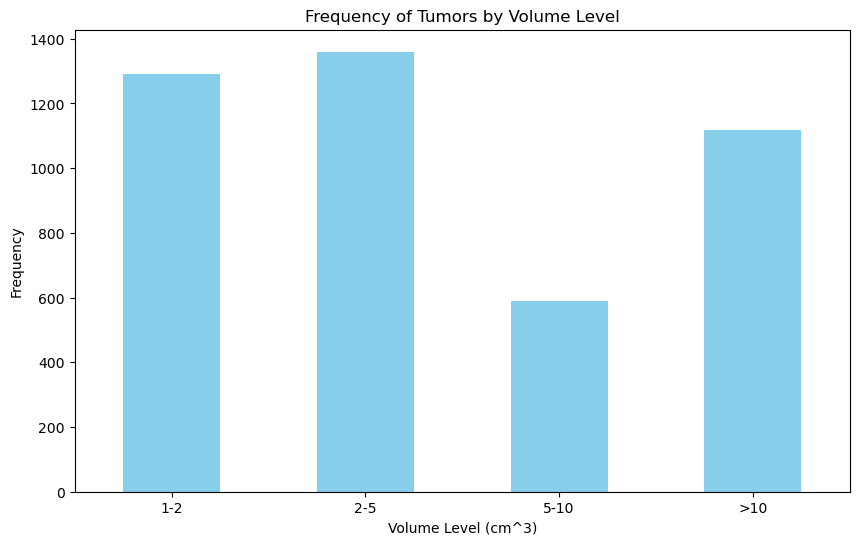

In [86]:
# Count the frequency of each volume level
volume_level_counts = filtered_non_clinical_important_tumor_df['Volume Level'].value_counts().reindex(labels)

# Plot a bar chart
plt.figure(figsize=(10, 6))
volume_level_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Tumors by Volume Level')
plt.xlabel('Volume Level (cm^3)')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the labels on the x-axis vertical
plt.show()

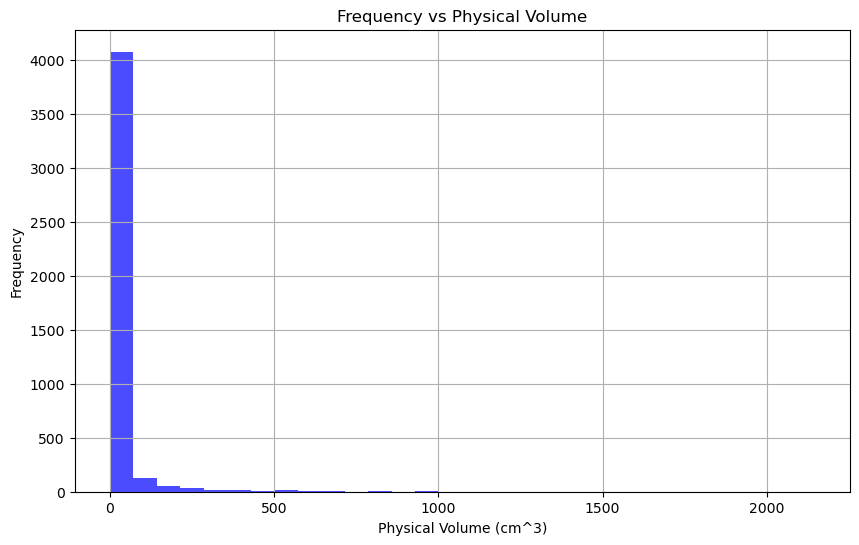

In [80]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_non_clinical_important_tumor_df['Physical Vol(cm^3)'], bins=30, alpha=0.7, color='blue')
plt.title('Frequency vs Physical Volume')
plt.xlabel('Physical Volume (cm^3)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

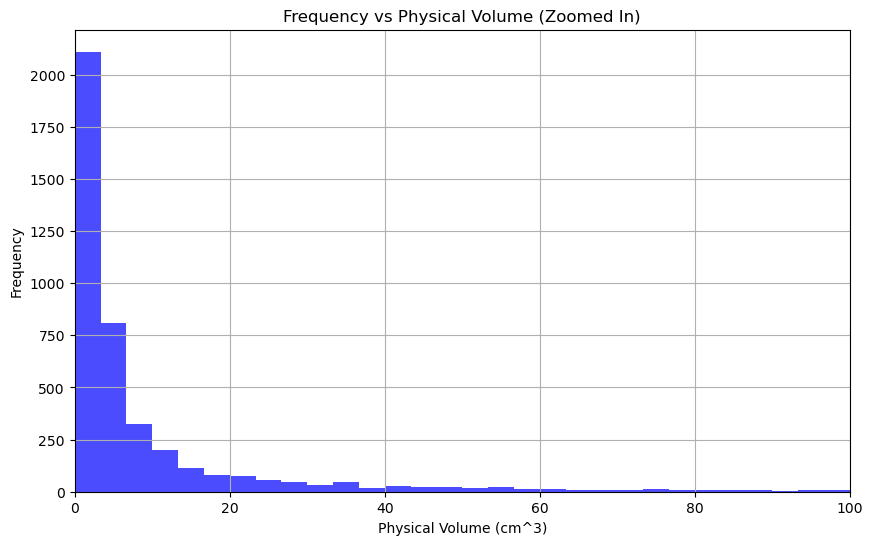

In [77]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_non_clinical_important_tumor_df['Physical Vol(cm^3)'], bins=30, alpha=0.7, color='blue', range=[0, 100])
plt.title('Frequency vs Physical Volume (Zoomed In)')
plt.xlabel('Physical Volume (cm^3)')
plt.ylabel('Frequency')
plt.xlim(left=0, right=100)  # Set X_max to the maximum value of the x-axis you want to display
plt.grid(True)
plt.show()

In [11]:
raw_df.groupby(['Patient ID', 'Study ID']).size()
num_unique_patients = raw_df.groupby(['Patient ID']).size()
assert num_unique_patients.shape[0] == 900

In [13]:
num_unique_studies = raw_df.groupby(['Patient ID', 'Study ID']).size()
assert num_unique_studies.shape[0] == 1014

In [88]:
raw_df[raw_df['Patient ID'] == 'PETCT_1285b86bea'].iloc[:,4].max()

173.8508

In [89]:
raw_df[raw_df['Patient ID'] == 'PETCT_1285b86bea'].iloc[:,4].min()

0.0124

In [90]:
raw_df[raw_df['Patient ID'] == 'PETCT_1285b86bea'].iloc[:,4].argmax()

362

In [91]:
raw_df[(raw_df['Patient ID'] == 'PETCT_1285b86bea') & (raw_df['In Diameter(cm)'] >= 1)]

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
377,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,5,361,4.4912,1.6499,7.5732,2.6310,39.0494
379,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,7,2298,28.5895,3.0578,10.0372,2.6282,57.5085
380,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,8,150,1.8662,1.2312,10.7578,3.4023,35.1634
382,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,10,102,1.2690,1.0826,7.6690,2.6542,36.9239
385,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,13,527,6.5564,1.8716,11.3898,3.2828,56.0073
...,...,...,...,...,...,...,...,...,...
1385,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1013,174,2.1647,1.2936,8.3292,2.6173,39.5732
1386,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1014,187,2.3265,1.3251,7.7361,3.2775,36.0632
1387,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1015,612,7.6139,1.9673,9.5217,2.6248,53.8450
1388,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1016,754,9.3805,2.1090,9.4717,3.2761,25.9308


In [ ]:
path = '../all_patients_results.csv'
raw_df = pd.read_csv(path)
raw_df.head()